In [1]:
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )

In [2]:
def activation(name):
    if name in ['tanh', 'Tanh']:
        return nn.Tanh()
    elif name in ['relu', 'ReLU']:
        return nn.ReLU(inplace=True)
    elif name in ['lrelu', 'LReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name in ['sigmoid', 'Sigmoid']:
        return nn.Sigmoid()
    elif name in ['softplus', 'Softplus']:
        return nn.Softplus(beta=4)
    elif name in ['celu', 'CeLU']:
        return nn.CELU()
    elif name in ['elu']:
        return nn.ELU()
    elif name in ['mish']:
        return nn.Mish()
    else:
        raise ValueError('Unknown activation function')




################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()
        
        self.regularization_exp = 1
        self.regularization_param = 0.0000001

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.complex128))

    
    # Complex multiplication
    def compl_mul1d(self, input, weights):
        #print("einsum: input, weights", input.shape, weights.shape)
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)

        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # x.shape == [batch_size, in_channels, number of grid points]
        # hint: use torch.fft library torch.fft.rfft
        # use DFT to approximate the fourier transform
        
        # Compute Fourier coefficients
        #print("x before fft", x.shape)
        x_ft = torch.fft.rfft(x)
        #print("x after fft", x.shape)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, device=x.device, dtype=torch.complex128)
        #print("outft shape", out_ft.shape)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :,:self.modes1], self.weights1)

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x
    
    def regularization(self):
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(param, self.regularization_exp)
        return self.regularization_param * reg_loss
    


####################################################################


class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()
        self.modes1 = modes
        self.width = width
        self.padding = 1  # pad the domain if input is non-periodic
        self.linear_p = nn.Linear(3, self.width, dtype=torch.float64)

        self.spect1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.lin0 = nn.Conv1d(self.width, self.width, 1, dtype = torch.float64)
        self.lin1 = nn.Conv1d(self.width, self.width, 1, dtype = torch.float64)
        self.lin2 = nn.Conv1d(self.width, self.width, 1, dtype = torch.float64)

        self.linear_q = nn.Linear(self.width, 32, dtype = torch.float64)
        self.output_layer = nn.Linear(32, 2, dtype = torch.float64)

        self.activation = torch.nn.Tanh()

    def fourier_layer(self, x, spectral_layer, conv_layer):
        return self.activation(spectral_layer(x) + conv_layer(x))

    def linear_layer(self, x, linear_transformation):
        return self.activation(linear_transformation(x))
    
    def forward(self, x):
        # grid = self.get_grid(x.shape, x.device)
        # x = torch.cat((x, grid), dim=-1)
        #print("x before linear_ü",x.shape)
        x = self.linear_p(x)
        #print("x after linear_p",x.shape)
        x = x.permute(0, 2, 1)
        #print("x after permute",x.shape)

        x = F.pad(x, [0, self.padding])  # pad the domain if input is non-periodic

        x = self.fourier_layer(x, self.spect1, self.lin0)
        x = self.fourier_layer(x, self.spect2, self.lin1)
        x = self.fourier_layer(x, self.spect3, self.lin2)

        x = x[..., :-self.padding]  # pad the domain if input is non-periodic

        x = x.permute(0, 2, 1)
        #print("x after permute",x.shape)

        x = self.linear_layer(x, self.linear_q)
        x = self.output_layer(x)
        return x
    
    def compute_loss(self, pred, train):
        l = torch.nn.MSELoss()
        loss = l(pred, train) + self.spect1.regularization() + self.spect2.regularization() + self.spect3.regularization()
        #loss = tuple(loss)
        return loss
    

    

In [3]:
torch.manual_seed(0)
np.random.seed(0)
import pandas as pd
n_train = 4

df = pd.read_csv(r'C:\Users\matth\OneDrive\Documents\TrainingData.txt')
data_read= df.iloc[:,0:3].values

data_read = torch.tensor(data_read).to(torch.float64)
print(data_read.shape)

Time_Column = torch.clone(data_read[:, 0])
Tf_Column = torch.clone(data_read[:, 1])
Ts_Column = torch.clone(data_read[:, 2])


data_read[:, 0] = Tf_Column
data_read[:, 1] = Ts_Column
data_read[:, 2] = Time_Column


max_Tf = torch.max(data_read[:,0])
max_Ts = torch.max(data_read[:,1])
min_Tf = torch.min(data_read[:,0])
min_Ts = torch.min(data_read[:,1])

data_read[:,0] = (data_read[:,0] - torch.full_like(data_read[:,0], min_Tf))/(max_Tf - min_Tf)
data_read[:,1] = (data_read[:,1] - torch.full_like(data_read[:,0], min_Ts))/(max_Ts - min_Ts)
data_read[:,2] /= 602168.58


data_read = data_read.unsqueeze(0)


data_altered = torch.tensor(()).to(torch.float64)

for i in range (0, 6):
    data_altered = torch.cat([data_altered, data_read[:,0+35*i:35+35*i]], dim=0)
    
x_data = data_altered[0:5,:,0:3]
y_data = data_altered[1:6,:,0:2]

input_function_train = x_data.to(device)#[:n_train, :].to(device)
output_function_train = y_data.to(device)#[:n_train, :].to(device)
#input_function_test = x_data[n_train:, :].to(device)
#output_function_test = y_data[n_train:, :].to(device)
print(output_function_train.shape)
#print(output_function_test.shape)


batch_size = 5 

training_set = DataLoader(TensorDataset(input_function_train, output_function_train), batch_size=batch_size, shuffle=False)
#testing_set = DataLoader(TensorDataset(input_function_test, output_function_test), batch_size=batch_size, shuffle=False)



torch.Size([210, 3])
torch.Size([5, 35, 2])


In [11]:
learning_rate = 0.001

# epochs = 250
epochs = 4000
step_size = 100
gamma = 0.75

modes = 19
width = 256

# model

fno = FNO1d(modes, width).to(device)

optimizer = Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)


l = torch.nn.MSELoss()
freq_print = 1
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set):
        optimizer.zero_grad()
        output_pred_batch = fno(input_batch)
        output_pred_batch = fno(input_batch).squeeze(0)
        output_batch = output_batch.squeeze(0)
        loss_f = torch.log10(l(output_pred_batch, output_batch))
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set)

    scheduler.step()
    
    """
    with torch.no_grad():
        fno.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(testing_set):
            output_pred_batch = fno(input_batch).squeeze(2)
            loss_f = torch.log10(l(output_pred_batch, output_batch))
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_set)
     """   
        
    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse,)# " ######### Relative L2 Test Norm:", test_relative_l2)
    


######### Epoch: 0  ######### Train Loss: -0.07440671297675358
######### Epoch: 1  ######### Train Loss: -0.7817639313211623
######### Epoch: 2  ######### Train Loss: -1.228702284624671
######### Epoch: 3  ######### Train Loss: -1.088766774890649
######### Epoch: 4  ######### Train Loss: -1.710122365174718
######### Epoch: 5  ######### Train Loss: -1.08014567373773
######### Epoch: 6  ######### Train Loss: -0.9425957590005524
######### Epoch: 7  ######### Train Loss: -1.1117317915082008
######### Epoch: 8  ######### Train Loss: -1.2748812677251786
######### Epoch: 9  ######### Train Loss: -1.2740276931646222
######### Epoch: 10  ######### Train Loss: -1.316575442701278
######### Epoch: 11  ######### Train Loss: -1.3485630051206314
######### Epoch: 12  ######### Train Loss: -1.463344575675898
######### Epoch: 13  ######### Train Loss: -1.7345501007765625
######### Epoch: 14  ######### Train Loss: -1.8861294265004585
######### Epoch: 15  ######### Train Loss: -2.251523903111247
#########

######### Epoch: 135  ######### Train Loss: -3.6480657077543612
######### Epoch: 136  ######### Train Loss: -3.5399075872864243
######### Epoch: 137  ######### Train Loss: -3.76546722002962
######### Epoch: 138  ######### Train Loss: -3.62280801644738
######### Epoch: 139  ######### Train Loss: -3.7171579608314502
######### Epoch: 140  ######### Train Loss: -4.375589089422249
######### Epoch: 141  ######### Train Loss: -3.6708856302212314
######### Epoch: 142  ######### Train Loss: -3.6090595760406248
######### Epoch: 143  ######### Train Loss: -3.753288691691362
######### Epoch: 144  ######### Train Loss: -3.87465875052453
######### Epoch: 145  ######### Train Loss: -3.92564097014567
######### Epoch: 146  ######### Train Loss: -3.9765622127016194
######### Epoch: 147  ######### Train Loss: -3.8282994510973705
######### Epoch: 148  ######### Train Loss: -4.203079988802098
######### Epoch: 149  ######### Train Loss: -3.2962685171553594
######### Epoch: 150  ######### Train Loss: -2.9987

######### Epoch: 271  ######### Train Loss: -2.4149873971538893
######### Epoch: 272  ######### Train Loss: -2.4095378392501203
######### Epoch: 273  ######### Train Loss: -2.4257180390159707
######### Epoch: 274  ######### Train Loss: -2.4612199898259983
######### Epoch: 275  ######### Train Loss: -2.5155153115078286
######### Epoch: 276  ######### Train Loss: -2.5894136378307824
######### Epoch: 277  ######### Train Loss: -2.684672654895319
######### Epoch: 278  ######### Train Loss: -2.8029479923377907
######### Epoch: 279  ######### Train Loss: -2.9420098284633163
######### Epoch: 280  ######### Train Loss: -3.0843731432870185
######### Epoch: 281  ######### Train Loss: -3.18197954900995
######### Epoch: 282  ######### Train Loss: -3.1938819388284982
######### Epoch: 283  ######### Train Loss: -3.1613999965857413
######### Epoch: 284  ######### Train Loss: -3.1501554509994114
######### Epoch: 285  ######### Train Loss: -3.1940058127638893
######### Epoch: 286  ######### Train Loss:

######### Epoch: 409  ######### Train Loss: -4.188306108886919
######### Epoch: 410  ######### Train Loss: -4.2778387602502645
######### Epoch: 411  ######### Train Loss: -4.360986669266656
######### Epoch: 412  ######### Train Loss: -4.5035499800315195
######### Epoch: 413  ######### Train Loss: -4.711342460363236
######### Epoch: 414  ######### Train Loss: -5.01262184758909
######### Epoch: 415  ######### Train Loss: -4.80767834281724
######### Epoch: 416  ######### Train Loss: -5.112624825186484
######### Epoch: 417  ######### Train Loss: -4.927747605579049
######### Epoch: 418  ######### Train Loss: -5.0943221694765
######### Epoch: 419  ######### Train Loss: -5.420593266985613
######### Epoch: 420  ######### Train Loss: -4.251792679830043
######### Epoch: 421  ######### Train Loss: -3.883724389343749
######### Epoch: 422  ######### Train Loss: -3.804231569220914
######### Epoch: 423  ######### Train Loss: -3.870232888075713
######### Epoch: 424  ######### Train Loss: -4.0228921692

######### Epoch: 545  ######### Train Loss: -4.940901134616285
######### Epoch: 546  ######### Train Loss: -4.699873244570259
######### Epoch: 547  ######### Train Loss: -4.506322448352343
######### Epoch: 548  ######### Train Loss: -4.659887800411886
######### Epoch: 549  ######### Train Loss: -5.040149144159583
######### Epoch: 550  ######### Train Loss: -4.942596921791395
######### Epoch: 551  ######### Train Loss: -5.067552316448486
######### Epoch: 552  ######### Train Loss: -5.009912494861363
######### Epoch: 553  ######### Train Loss: -5.339239899169672
######### Epoch: 554  ######### Train Loss: -4.696399221646037
######### Epoch: 555  ######### Train Loss: -4.466335746273504
######### Epoch: 556  ######### Train Loss: -4.65018107189166
######### Epoch: 557  ######### Train Loss: -5.171673308036073
######### Epoch: 558  ######### Train Loss: -4.8401498843961965
######### Epoch: 559  ######### Train Loss: -4.89425577273098
######### Epoch: 560  ######### Train Loss: -5.038310933

######### Epoch: 682  ######### Train Loss: -4.693350402285192
######### Epoch: 683  ######### Train Loss: -4.777234857075594
######### Epoch: 684  ######### Train Loss: -4.873045981669751
######### Epoch: 685  ######### Train Loss: -5.065651672184271
######### Epoch: 686  ######### Train Loss: -5.253453093946999
######### Epoch: 687  ######### Train Loss: -5.170600103562518
######### Epoch: 688  ######### Train Loss: -5.137143850719991
######### Epoch: 689  ######### Train Loss: -5.175486556391391
######### Epoch: 690  ######### Train Loss: -5.166165357725419
######### Epoch: 691  ######### Train Loss: -5.346813825885143
######### Epoch: 692  ######### Train Loss: -5.992344344460281
######### Epoch: 693  ######### Train Loss: -5.504110352443351
######### Epoch: 694  ######### Train Loss: -5.480211408645438
######### Epoch: 695  ######### Train Loss: -5.4271306243593065
######### Epoch: 696  ######### Train Loss: -5.792774889726612
######### Epoch: 697  ######### Train Loss: -5.2225805

######### Epoch: 819  ######### Train Loss: -4.806747135451584
######### Epoch: 820  ######### Train Loss: -4.90898678158593
######### Epoch: 821  ######### Train Loss: -5.028741592484101
######### Epoch: 822  ######### Train Loss: -5.1586758510647455
######### Epoch: 823  ######### Train Loss: -5.336740136745124
######### Epoch: 824  ######### Train Loss: -5.555164150389504
######### Epoch: 825  ######### Train Loss: -5.683326334421445
######### Epoch: 826  ######### Train Loss: -5.7481027046260875
######### Epoch: 827  ######### Train Loss: -5.5218984372110045
######### Epoch: 828  ######### Train Loss: -5.667772875276296
######### Epoch: 829  ######### Train Loss: -5.82961127096405
######### Epoch: 830  ######### Train Loss: -6.02010054824912
######### Epoch: 831  ######### Train Loss: -5.6642481274080865
######### Epoch: 832  ######### Train Loss: -5.4677521204098385
######### Epoch: 833  ######### Train Loss: -5.51648585075535
######### Epoch: 834  ######### Train Loss: -5.6910410

######### Epoch: 958  ######### Train Loss: -5.803550133654448
######### Epoch: 959  ######### Train Loss: -6.305912937415687
######### Epoch: 960  ######### Train Loss: -5.976545836354625
######### Epoch: 961  ######### Train Loss: -6.303740366733181
######### Epoch: 962  ######### Train Loss: -5.91107005708784
######### Epoch: 963  ######### Train Loss: -6.18828937513399
######### Epoch: 964  ######### Train Loss: -5.624196959069576
######### Epoch: 965  ######### Train Loss: -5.339333392272403
######### Epoch: 966  ######### Train Loss: -5.4482160232496435
######### Epoch: 967  ######### Train Loss: -6.217103751883887
######### Epoch: 968  ######### Train Loss: -5.235328665513988
######### Epoch: 969  ######### Train Loss: -4.70617085026821
######### Epoch: 970  ######### Train Loss: -4.464396596658802
######### Epoch: 971  ######### Train Loss: -4.330431395693171
######### Epoch: 972  ######### Train Loss: -4.2552391307946005
######### Epoch: 973  ######### Train Loss: -4.219087409

######### Epoch: 1097  ######### Train Loss: -6.384581347985589
######### Epoch: 1098  ######### Train Loss: -6.300954806957786
######### Epoch: 1099  ######### Train Loss: -6.477537703607951
######### Epoch: 1100  ######### Train Loss: -6.128407156734569
######### Epoch: 1101  ######### Train Loss: -6.142575911130594
######### Epoch: 1102  ######### Train Loss: -6.700899742444373
######### Epoch: 1103  ######### Train Loss: -6.4159772837445
######### Epoch: 1104  ######### Train Loss: -6.437491039293101
######### Epoch: 1105  ######### Train Loss: -6.367842986314921
######### Epoch: 1106  ######### Train Loss: -7.223573043859546
######### Epoch: 1107  ######### Train Loss: -5.717316723475365
######### Epoch: 1108  ######### Train Loss: -5.219843540372278
######### Epoch: 1109  ######### Train Loss: -4.980168775707597
######### Epoch: 1110  ######### Train Loss: -4.8400078962301825
######### Epoch: 1111  ######### Train Loss: -4.753644513579588
######### Epoch: 1112  ######### Train Lo

######### Epoch: 1225  ######### Train Loss: -5.965291512170145
######### Epoch: 1226  ######### Train Loss: -6.14129708253362
######### Epoch: 1227  ######### Train Loss: -6.297035555432349
######### Epoch: 1228  ######### Train Loss: -6.460900208639303
######### Epoch: 1229  ######### Train Loss: -6.540587435259584
######### Epoch: 1230  ######### Train Loss: -6.504508401410301
######### Epoch: 1231  ######### Train Loss: -6.704243842005797
######### Epoch: 1232  ######### Train Loss: -6.809911061717521
######### Epoch: 1233  ######### Train Loss: -6.711263726962447
######### Epoch: 1234  ######### Train Loss: -6.828760652411109
######### Epoch: 1235  ######### Train Loss: -6.8482475632927455
######### Epoch: 1236  ######### Train Loss: -7.192851929704433
######### Epoch: 1237  ######### Train Loss: -7.171096399260035
######### Epoch: 1238  ######### Train Loss: -6.182095639881331
######### Epoch: 1239  ######### Train Loss: -5.826029317476872
######### Epoch: 1240  ######### Train L

######### Epoch: 1364  ######### Train Loss: -6.137990352315967
######### Epoch: 1365  ######### Train Loss: -6.450616364026444
######### Epoch: 1366  ######### Train Loss: -7.000423561720042
######### Epoch: 1367  ######### Train Loss: -6.849835623909071
######### Epoch: 1368  ######### Train Loss: -6.771226545895432
######### Epoch: 1369  ######### Train Loss: -6.797450747565425
######### Epoch: 1370  ######### Train Loss: -7.148237095744818
######### Epoch: 1371  ######### Train Loss: -7.275954046098763
######### Epoch: 1372  ######### Train Loss: -6.440727015372313
######### Epoch: 1373  ######### Train Loss: -6.09918995926946
######### Epoch: 1374  ######### Train Loss: -6.086341061106001
######### Epoch: 1375  ######### Train Loss: -6.31110904203614
######### Epoch: 1376  ######### Train Loss: -6.7959009110381885
######### Epoch: 1377  ######### Train Loss: -6.566344586079395
######### Epoch: 1378  ######### Train Loss: -6.476267109998775
######### Epoch: 1379  ######### Train Lo

######### Epoch: 1500  ######### Train Loss: -6.244147940861041
######### Epoch: 1501  ######### Train Loss: -6.14125173529943
######### Epoch: 1502  ######### Train Loss: -6.144390398411977
######### Epoch: 1503  ######### Train Loss: -6.234070580666765
######### Epoch: 1504  ######### Train Loss: -6.420950499297544
######### Epoch: 1505  ######### Train Loss: -6.72850262823526
######### Epoch: 1506  ######### Train Loss: -7.019192655612699
######### Epoch: 1507  ######### Train Loss: -7.040570425333111
######### Epoch: 1508  ######### Train Loss: -6.973855962052266
######### Epoch: 1509  ######### Train Loss: -6.986598685802811
######### Epoch: 1510  ######### Train Loss: -7.142971476745663
######### Epoch: 1511  ######### Train Loss: -7.1202379922138395
######### Epoch: 1512  ######### Train Loss: -7.245388590925083
######### Epoch: 1513  ######### Train Loss: -7.312299974509996
######### Epoch: 1514  ######### Train Loss: -7.268220684860421
######### Epoch: 1515  ######### Train Lo

######### Epoch: 1639  ######### Train Loss: -6.72815895650401
######### Epoch: 1640  ######### Train Loss: -6.795364830507328
######### Epoch: 1641  ######### Train Loss: -7.005471177419803
######### Epoch: 1642  ######### Train Loss: -7.384932645175478
######### Epoch: 1643  ######### Train Loss: -7.511714121441585
######### Epoch: 1644  ######### Train Loss: -7.326767587802672
######### Epoch: 1645  ######### Train Loss: -7.428914664085658
######### Epoch: 1646  ######### Train Loss: -7.708245066667229
######### Epoch: 1647  ######### Train Loss: -7.6856374250950275
######### Epoch: 1648  ######### Train Loss: -7.647904068604894
######### Epoch: 1649  ######### Train Loss: -7.6398696861557545
######### Epoch: 1650  ######### Train Loss: -8.100246060118604
######### Epoch: 1651  ######### Train Loss: -7.136062125507185
######### Epoch: 1652  ######### Train Loss: -6.791332197312338
######### Epoch: 1653  ######### Train Loss: -6.760968825557947
######### Epoch: 1654  ######### Train 

######### Epoch: 1776  ######### Train Loss: -7.681429312859067
######### Epoch: 1777  ######### Train Loss: -7.862635368892369
######### Epoch: 1778  ######### Train Loss: -8.027567402729513
######### Epoch: 1779  ######### Train Loss: -7.561790703766327
######### Epoch: 1780  ######### Train Loss: -7.311092600993475
######### Epoch: 1781  ######### Train Loss: -7.545345315151344
######### Epoch: 1782  ######### Train Loss: -8.211584403407711
######### Epoch: 1783  ######### Train Loss: -8.180500612433868
######### Epoch: 1784  ######### Train Loss: -7.834535429376811
######### Epoch: 1785  ######### Train Loss: -7.80689412849144
######### Epoch: 1786  ######### Train Loss: -8.221987744067594
######### Epoch: 1787  ######### Train Loss: -7.453541220460903
######### Epoch: 1788  ######### Train Loss: -7.043769346945322
######### Epoch: 1789  ######### Train Loss: -6.949395031210166
######### Epoch: 1790  ######### Train Loss: -7.012301669344871
######### Epoch: 1791  ######### Train Lo

######### Epoch: 1905  ######### Train Loss: -8.276334135479887
######### Epoch: 1906  ######### Train Loss: -8.487375356396521
######### Epoch: 1907  ######### Train Loss: -8.481315801545458
######### Epoch: 1908  ######### Train Loss: -8.809127060516909
######### Epoch: 1909  ######### Train Loss: -7.822581256487854
######### Epoch: 1910  ######### Train Loss: -7.393993523465592
######### Epoch: 1911  ######### Train Loss: -7.235787702161898
######### Epoch: 1912  ######### Train Loss: -7.1872644803974275
######### Epoch: 1913  ######### Train Loss: -7.2062157646971485
######### Epoch: 1914  ######### Train Loss: -7.278780340552602
######### Epoch: 1915  ######### Train Loss: -7.404129531663389
######### Epoch: 1916  ######### Train Loss: -7.5964141680385335
######### Epoch: 1917  ######### Train Loss: -7.9111941292906796
######### Epoch: 1918  ######### Train Loss: -8.455573004057207
######### Epoch: 1919  ######### Train Loss: -8.016653762769595
######### Epoch: 1920  ######### Tra

######### Epoch: 2041  ######### Train Loss: -8.511948853205203
######### Epoch: 2042  ######### Train Loss: -8.52258823167097
######### Epoch: 2043  ######### Train Loss: -8.414580271597826
######### Epoch: 2044  ######### Train Loss: -8.806735835498904
######### Epoch: 2045  ######### Train Loss: -8.163997655795475
######### Epoch: 2046  ######### Train Loss: -7.900374296868966
######### Epoch: 2047  ######### Train Loss: -8.023027439866697
######### Epoch: 2048  ######### Train Loss: -8.516528959827713
######### Epoch: 2049  ######### Train Loss: -8.16198019975874
######### Epoch: 2050  ######### Train Loss: -7.974337428035715
######### Epoch: 2051  ######### Train Loss: -8.19273621509776
######### Epoch: 2052  ######### Train Loss: -8.677312577442603
######### Epoch: 2053  ######### Train Loss: -8.43524743205113
######### Epoch: 2054  ######### Train Loss: -8.65614006492091
######### Epoch: 2055  ######### Train Loss: -8.535634879095083
######### Epoch: 2056  ######### Train Loss: 

######### Epoch: 2172  ######### Train Loss: -8.364046470905393
######### Epoch: 2173  ######### Train Loss: -8.843667382063968
######### Epoch: 2174  ######### Train Loss: -8.583034811888872
######### Epoch: 2175  ######### Train Loss: -8.478300902188288
######### Epoch: 2176  ######### Train Loss: -8.705615772144112
######### Epoch: 2177  ######### Train Loss: -8.850999327708719
######### Epoch: 2178  ######### Train Loss: -8.681197854123226
######### Epoch: 2179  ######### Train Loss: -8.762090598566887
######### Epoch: 2180  ######### Train Loss: -9.15534926994689
######### Epoch: 2181  ######### Train Loss: -9.313820645621057
######### Epoch: 2182  ######### Train Loss: -8.362467289904103
######### Epoch: 2183  ######### Train Loss: -8.03539719733212
######### Epoch: 2184  ######### Train Loss: -8.028718191597457
######### Epoch: 2185  ######### Train Loss: -8.268983707596144
######### Epoch: 2186  ######### Train Loss: -8.851892290930273
######### Epoch: 2187  ######### Train Los

######### Epoch: 2304  ######### Train Loss: -8.451997461640062
######### Epoch: 2305  ######### Train Loss: -8.884171918049244
######### Epoch: 2306  ######### Train Loss: -9.122886786896796
######### Epoch: 2307  ######### Train Loss: -8.905571563009756
######### Epoch: 2308  ######### Train Loss: -9.110296621954552
######### Epoch: 2309  ######### Train Loss: -9.144018960774916
######### Epoch: 2310  ######### Train Loss: -9.196524636778307
######### Epoch: 2311  ######### Train Loss: -9.113245968559443
######### Epoch: 2312  ######### Train Loss: -9.153602731358244
######### Epoch: 2313  ######### Train Loss: -9.55910601323702
######### Epoch: 2314  ######### Train Loss: -9.775674678920874
######### Epoch: 2315  ######### Train Loss: -8.787009578184609
######### Epoch: 2316  ######### Train Loss: -8.496608043350575
######### Epoch: 2317  ######### Train Loss: -8.547210357584438
######### Epoch: 2318  ######### Train Loss: -8.965186707717496
######### Epoch: 2319  ######### Train Lo

######### Epoch: 2437  ######### Train Loss: -9.60723341507068
######### Epoch: 2438  ######### Train Loss: -9.272027792114526
######### Epoch: 2439  ######### Train Loss: -9.153042847944668
######### Epoch: 2440  ######### Train Loss: -9.30566712925823
######### Epoch: 2441  ######### Train Loss: -9.380312283771557
######### Epoch: 2442  ######### Train Loss: -9.472647597242997
######### Epoch: 2443  ######### Train Loss: -9.453566559815574
######### Epoch: 2444  ######### Train Loss: -9.580151049324023
######### Epoch: 2445  ######### Train Loss: -9.394164283657917
######### Epoch: 2446  ######### Train Loss: -9.353007180158919
######### Epoch: 2447  ######### Train Loss: -9.975624374658986
######### Epoch: 2448  ######### Train Loss: -9.455598089294512
######### Epoch: 2449  ######### Train Loss: -9.547755705106606
######### Epoch: 2450  ######### Train Loss: -9.548508513319026
######### Epoch: 2451  ######### Train Loss: -9.791046716873135
######### Epoch: 2452  ######### Train Los

######### Epoch: 2571  ######### Train Loss: -10.203228048332834
######### Epoch: 2572  ######### Train Loss: -10.20064429247604
######### Epoch: 2573  ######### Train Loss: -10.180691068312859
######### Epoch: 2574  ######### Train Loss: -10.076749056046935
######### Epoch: 2575  ######### Train Loss: -9.994581017570512
######### Epoch: 2576  ######### Train Loss: -10.164916205645278
######### Epoch: 2577  ######### Train Loss: -10.204926481680426
######### Epoch: 2578  ######### Train Loss: -10.211573229131275
######### Epoch: 2579  ######### Train Loss: -10.212820631995225
######### Epoch: 2580  ######### Train Loss: -10.214768442718785
######### Epoch: 2581  ######### Train Loss: -10.21581506890545
######### Epoch: 2582  ######### Train Loss: -10.21631420618562
######### Epoch: 2583  ######### Train Loss: -10.207735295767462
######### Epoch: 2584  ######### Train Loss: -10.147474844530281
######### Epoch: 2585  ######### Train Loss: -9.984425725595003
######### Epoch: 2586  #######

######### Epoch: 2709  ######### Train Loss: -10.33426963531711
######### Epoch: 2710  ######### Train Loss: -10.321677771147446
######### Epoch: 2711  ######### Train Loss: -10.329421685683037
######### Epoch: 2712  ######### Train Loss: -10.340534179642356
######### Epoch: 2713  ######### Train Loss: -10.335034691252574
######### Epoch: 2714  ######### Train Loss: -10.32947561552406
######### Epoch: 2715  ######### Train Loss: -10.337756307471233
######### Epoch: 2716  ######### Train Loss: -10.343502774890164
######### Epoch: 2717  ######### Train Loss: -10.338811426171745
######### Epoch: 2718  ######### Train Loss: -10.336480902990049
######### Epoch: 2719  ######### Train Loss: -10.342661639724858
######### Epoch: 2720  ######### Train Loss: -10.346465359080746
######### Epoch: 2721  ######### Train Loss: -10.343605894553846
######### Epoch: 2722  ######### Train Loss: -10.34211907581304
######### Epoch: 2723  ######### Train Loss: -10.346190830480142
######### Epoch: 2724  #####

######### Epoch: 2837  ######### Train Loss: -10.431209503053259
######### Epoch: 2838  ######### Train Loss: -10.431929603402201
######### Epoch: 2839  ######### Train Loss: -10.432892069702529
######### Epoch: 2840  ######### Train Loss: -10.433414577073833
######### Epoch: 2841  ######### Train Loss: -10.433811806720207
######### Epoch: 2842  ######### Train Loss: -10.434580611839126
######### Epoch: 2843  ######### Train Loss: -10.435397680458198
######### Epoch: 2844  ######### Train Loss: -10.43590748311947
######### Epoch: 2845  ######### Train Loss: -10.43640758992294
######### Epoch: 2846  ######### Train Loss: -10.437155057278527
######### Epoch: 2847  ######### Train Loss: -10.437891961176852
######### Epoch: 2848  ######### Train Loss: -10.438429166768096
######### Epoch: 2849  ######### Train Loss: -10.438980718932575
######### Epoch: 2850  ######### Train Loss: -10.439692312550873
######### Epoch: 2851  ######### Train Loss: -10.440391738933366
######### Epoch: 2852  ####

######### Epoch: 2964  ######### Train Loss: -10.50341025269492
######### Epoch: 2965  ######### Train Loss: -10.503917492794148
######### Epoch: 2966  ######### Train Loss: -10.50442506564032
######### Epoch: 2967  ######### Train Loss: -10.504932971163518
######### Epoch: 2968  ######### Train Loss: -10.505441209903587
######### Epoch: 2969  ######### Train Loss: -10.505949782804914
######### Epoch: 2970  ######### Train Loss: -10.506458690143951
######### Epoch: 2971  ######### Train Loss: -10.506967932170028
######### Epoch: 2972  ######### Train Loss: -10.50747750974104
######### Epoch: 2973  ######### Train Loss: -10.507987423399285
######### Epoch: 2974  ######### Train Loss: -10.50849767334789
######### Epoch: 2975  ######### Train Loss: -10.50900826023199
######### Epoch: 2976  ######### Train Loss: -10.509519184757144
######### Epoch: 2977  ######### Train Loss: -10.510030447219624
######### Epoch: 2978  ######### Train Loss: -10.510542048093363
######### Epoch: 2979  #######

######### Epoch: 3092  ######### Train Loss: -10.558707432972687
######### Epoch: 3093  ######### Train Loss: -10.559118797273825
######### Epoch: 3094  ######### Train Loss: -10.55953040906613
######### Epoch: 3095  ######### Train Loss: -10.559942268633058
######### Epoch: 3096  ######### Train Loss: -10.560354376269153
######### Epoch: 3097  ######### Train Loss: -10.560766732271539
######### Epoch: 3098  ######### Train Loss: -10.561179336917043
######### Epoch: 3099  ######### Train Loss: -10.561592190514032
######### Epoch: 3100  ######### Train Loss: -10.562005293342501
######### Epoch: 3101  ######### Train Loss: -10.562315300713916
######### Epoch: 3102  ######### Train Loss: -10.562625480249903
######### Epoch: 3103  ######### Train Loss: -10.5629358308934
######### Epoch: 3104  ######### Train Loss: -10.56324635171275
######### Epoch: 3105  ######### Train Loss: -10.563557041874713
######### Epoch: 3106  ######### Train Loss: -10.563867900662098
######### Epoch: 3107  ######

######### Epoch: 3219  ######### Train Loss: -10.598514703812464
######### Epoch: 3220  ######### Train Loss: -10.598762171545218
######### Epoch: 3221  ######### Train Loss: -10.599009757119765
######### Epoch: 3222  ######### Train Loss: -10.599257460525711
######### Epoch: 3223  ######### Train Loss: -10.599505281770497
######### Epoch: 3224  ######### Train Loss: -10.59975322087266
######### Epoch: 3225  ######### Train Loss: -10.600001277843115
######### Epoch: 3226  ######### Train Loss: -10.600249452717827
######### Epoch: 3227  ######### Train Loss: -10.60049774552471
######### Epoch: 3228  ######### Train Loss: -10.60074615631855
######### Epoch: 3229  ######### Train Loss: -10.600994685133681
######### Epoch: 3230  ######### Train Loss: -10.601243332031984
######### Epoch: 3231  ######### Train Loss: -10.601492097056866
######### Epoch: 3232  ######### Train Loss: -10.60174098029334
######### Epoch: 3233  ######### Train Loss: -10.601989981783165
######### Epoch: 3234  ######

######### Epoch: 3355  ######### Train Loss: -10.62968525999042
######### Epoch: 3356  ######### Train Loss: -10.629882883765898
######### Epoch: 3357  ######### Train Loss: -10.630080593527605
######### Epoch: 3358  ######### Train Loss: -10.630278389332517
######### Epoch: 3359  ######### Train Loss: -10.630476271240083
######### Epoch: 3360  ######### Train Loss: -10.63067423930356
######### Epoch: 3361  ######### Train Loss: -10.630872293583668
######### Epoch: 3362  ######### Train Loss: -10.631070434138302
######### Epoch: 3363  ######### Train Loss: -10.631268661028965
######### Epoch: 3364  ######### Train Loss: -10.631466974314518
######### Epoch: 3365  ######### Train Loss: -10.631665374050828
######### Epoch: 3366  ######### Train Loss: -10.631863860296477
######### Epoch: 3367  ######### Train Loss: -10.632062433109
######### Epoch: 3368  ######### Train Loss: -10.632261092553415
######### Epoch: 3369  ######### Train Loss: -10.632459838682944
######### Epoch: 3370  #######

######### Epoch: 3492  ######### Train Loss: -10.652828710231448
######### Epoch: 3493  ######### Train Loss: -10.652985561107437
######### Epoch: 3494  ######### Train Loss: -10.65314247521709
######### Epoch: 3495  ######### Train Loss: -10.653299452599258
######### Epoch: 3496  ######### Train Loss: -10.653456493278657
######### Epoch: 3497  ######### Train Loss: -10.65361359730405
######### Epoch: 3498  ######### Train Loss: -10.653770764699559
######### Epoch: 3499  ######### Train Loss: -10.653927995512726
######### Epoch: 3500  ######### Train Loss: -10.654085289777498
######### Epoch: 3501  ######### Train Loss: -10.654203307075512
######### Epoch: 3502  ######### Train Loss: -10.654321369790104
######### Epoch: 3503  ######### Train Loss: -10.654439477749056
######### Epoch: 3504  ######### Train Loss: -10.654557630834677
######### Epoch: 3505  ######### Train Loss: -10.654675828913083
######### Epoch: 3506  ######### Train Loss: -10.654794071880293
######### Epoch: 3507  ####

######### Epoch: 3627  ######### Train Loss: -10.668600698250865
######### Epoch: 3628  ######### Train Loss: -10.668693463508635
######### Epoch: 3629  ######### Train Loss: -10.668786261292231
######### Epoch: 3630  ######### Train Loss: -10.668879091611783
######### Epoch: 3631  ######### Train Loss: -10.668971954481187
######### Epoch: 3632  ######### Train Loss: -10.669064849905215
######### Epoch: 3633  ######### Train Loss: -10.669157777904386
######### Epoch: 3634  ######### Train Loss: -10.669250738478937
######### Epoch: 3635  ######### Train Loss: -10.66934373164768
######### Epoch: 3636  ######### Train Loss: -10.669436757419112
######### Epoch: 3637  ######### Train Loss: -10.669529815804788
######### Epoch: 3638  ######### Train Loss: -10.66962290681761
######### Epoch: 3639  ######### Train Loss: -10.66971603047596
######### Epoch: 3640  ######### Train Loss: -10.669809186793412
######### Epoch: 3641  ######### Train Loss: -10.669902375770631
######### Epoch: 3642  #####

######### Epoch: 3754  ######### Train Loss: -10.679347998800157
######### Epoch: 3755  ######### Train Loss: -10.679420683501183
######### Epoch: 3756  ######### Train Loss: -10.679493392487283
######### Epoch: 3757  ######### Train Loss: -10.679566125787025
######### Epoch: 3758  ######### Train Loss: -10.67963888338361
######### Epoch: 3759  ######### Train Loss: -10.679711665318793
######### Epoch: 3760  ######### Train Loss: -10.679784471580252
######### Epoch: 3761  ######### Train Loss: -10.679857302181837
######### Epoch: 3762  ######### Train Loss: -10.679930157140548
######### Epoch: 3763  ######### Train Loss: -10.680003036460977
######### Epoch: 3764  ######### Train Loss: -10.680075940149624
######### Epoch: 3765  ######### Train Loss: -10.68014886822296
######### Epoch: 3766  ######### Train Loss: -10.680221820686995
######### Epoch: 3767  ######### Train Loss: -10.680294797554117
######### Epoch: 3768  ######### Train Loss: -10.680367798837764
######### Epoch: 3769  ####

######### Epoch: 3889  ######### Train Loss: -10.687714180009108
######### Epoch: 3890  ######### Train Loss: -10.687771145838061
######### Epoch: 3891  ######### Train Loss: -10.687828129977
######### Epoch: 3892  ######### Train Loss: -10.687885132449649
######### Epoch: 3893  ######### Train Loss: -10.68794215324615
######### Epoch: 3894  ######### Train Loss: -10.687999192378616
######### Epoch: 3895  ######### Train Loss: -10.688056249855851
######### Epoch: 3896  ######### Train Loss: -10.688113325684908
######### Epoch: 3897  ######### Train Loss: -10.688170419869488
######### Epoch: 3898  ######### Train Loss: -10.688227532414007
######### Epoch: 3899  ######### Train Loss: -10.688284663334858
######### Epoch: 3900  ######### Train Loss: -10.688341812629021
######### Epoch: 3901  ######### Train Loss: -10.688384688259948
######### Epoch: 3902  ######### Train Loss: -10.688427577405948
######### Epoch: 3903  ######### Train Loss: -10.688470480047132
######### Epoch: 3904  ######

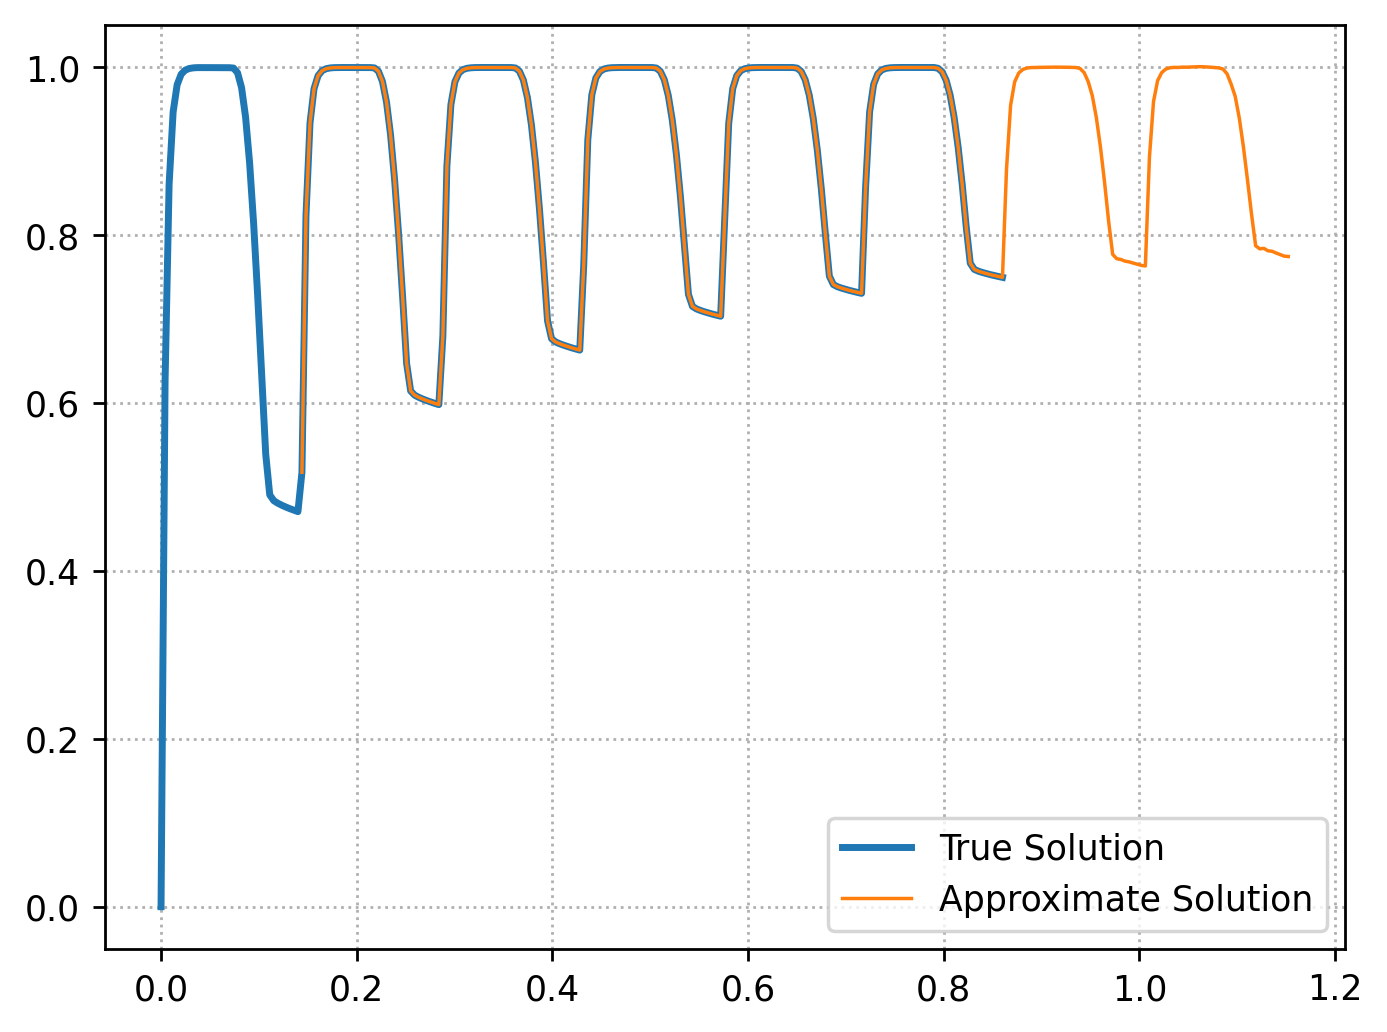

In [12]:
test_read = pd.read_csv(r'C:\Users\matth\OneDrive\Documents\TestingData.txt')
test_read = test_read.iloc[:,0:1].values
test_read = torch.tensor(test_read).to(torch.float64).squeeze(1).to(device)
test_read /= 602168.58

output_function_test_0 = fno(input_function_train[0,:,:].unsqueeze(0))
output_function_test_1 = fno(input_function_train[1,:,:].unsqueeze(0))
output_function_test_2 = fno(input_function_train[2,:,:].unsqueeze(0))
output_function_test_3 = fno(input_function_train[3,:,:].unsqueeze(0))
output_function_test_4 = fno(input_function_train[4,:,:].unsqueeze(0))
output_function_test_5 = fno(data_read[:,175:210].to(device))


interval = torch.linspace(520392.6,693856.8, 70).to(device)
interval /=  602168.58
next_step = torch.cat((output_function_test_5, interval[:35].unsqueeze(0).unsqueeze(2)), dim=2)
output_function_test_6 = fno(next_step)


input_function_pred = torch.cat((input_function_train[1,:,2], input_function_train[2,:,2], input_function_train[3,:,2], input_function_train[4,:,2], data_read[:,175:210,2].squeeze(0).to(device), interval), dim=0)
output_function_pred = torch.cat((output_function_test_0, output_function_test_1, output_function_test_2, output_function_test_3, output_function_test_4, output_function_test_5, output_function_test_6), dim=1)

input_function_plot = torch.cat((input_function_train[0,:,2], input_function_train[1,:,2], input_function_train[2,:,2], input_function_train[3,:,2], input_function_train[4,:,2], data_read[:,175:210,2].squeeze(0).to(device)), dim=0)
output_function_plot = torch.cat((input_function_train[0,:,1], input_function_train[1,:,1], input_function_train[2,:,1], input_function_train[3,:,1], input_function_train[4,:,1], output_function_train[4,:,1]), dim=0)

#loss = torch.nn.MSELoss()
#print("loss is",torch.log10(loss(output_function_train[0,:,:], output_function_test_0.squeeze(0))))

diff = abs(output_function_pred[:,:175, 0] - output_function_plot[35:]).squeeze(0)

plt.figure(dpi=250)
plt.grid(True, which="both", ls=":")

plt.plot(input_function_plot.cpu().detach(), output_function_plot.cpu().detach(), label="True Solution", c="C0", lw=2)
plt.plot(input_function_pred.cpu().detach(), output_function_pred[:,:,1].squeeze(0).cpu().detach(), label="Approximate Solution", c="C1", lw=1)
#plt.plot(input_function_plot[35:].cpu().detach(), diff.cpu().detach(), label="True Solution", c="C0", lw=2)
                                                                            
                                                                                
                                                                                
plt.legend()
plt.show()


torch.Size([1, 34, 2])
torch.Size([209]) torch.Size([1, 209, 2])
torch.Size([1, 209, 2])


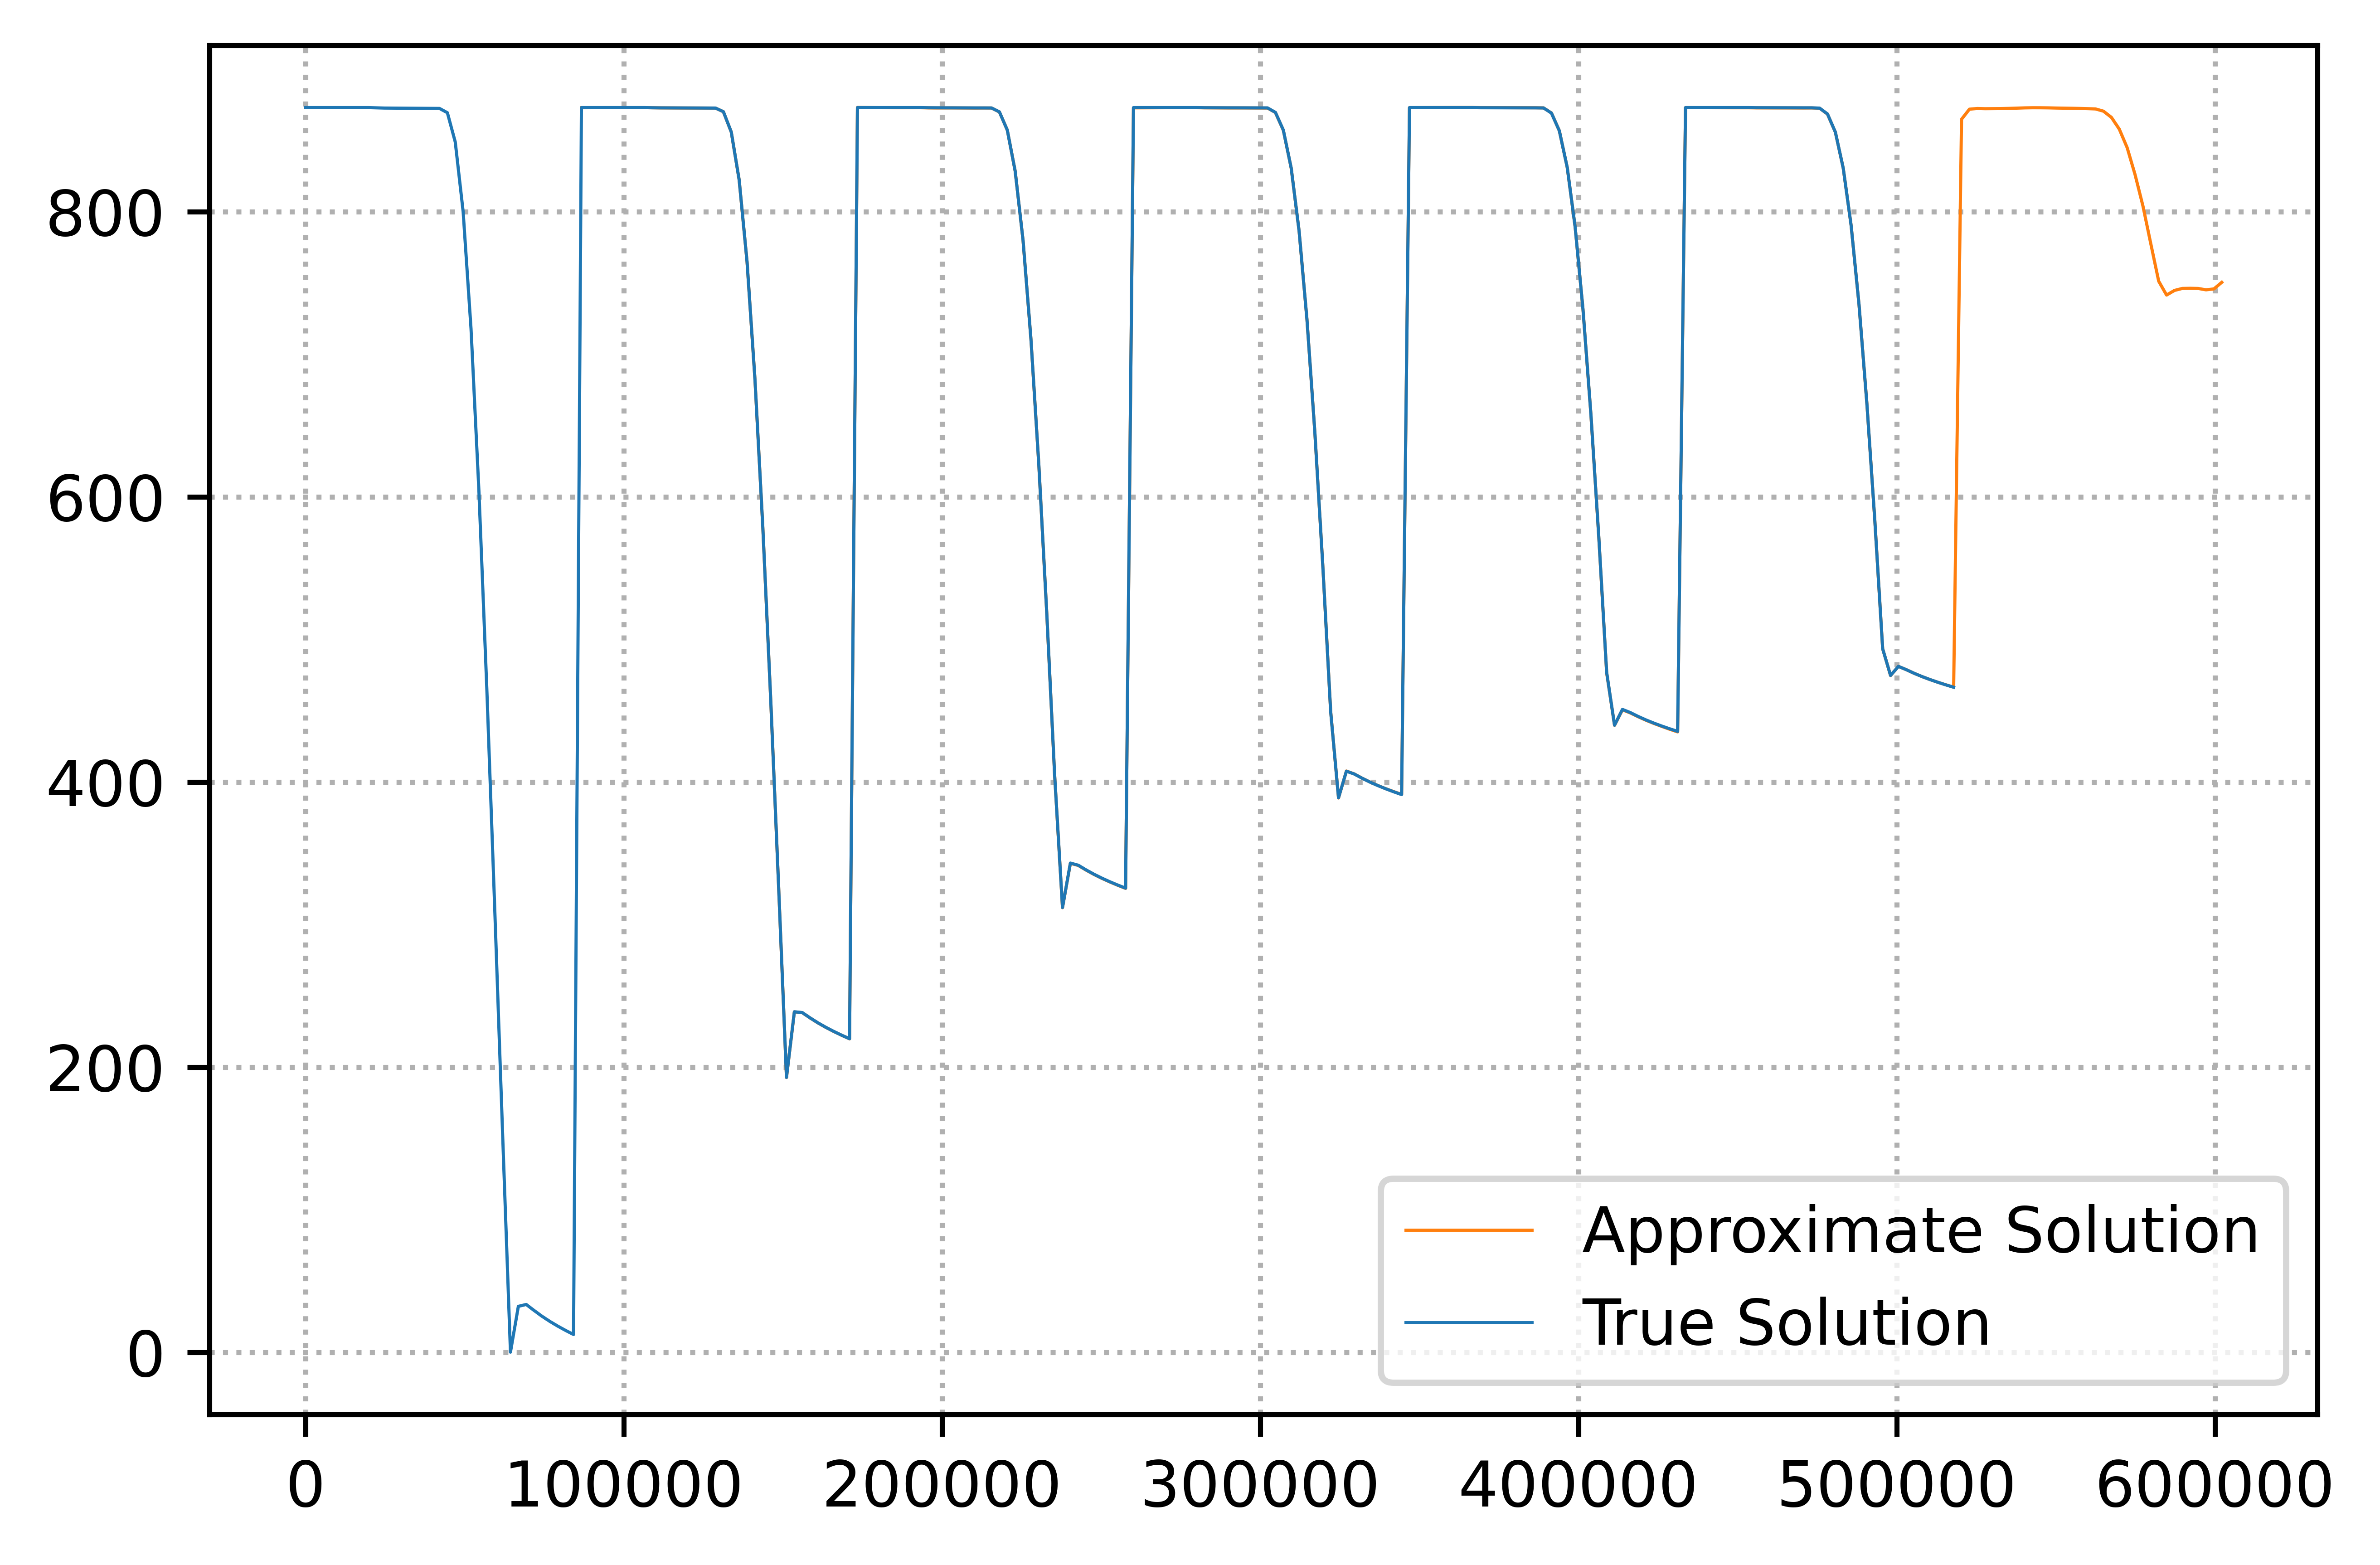

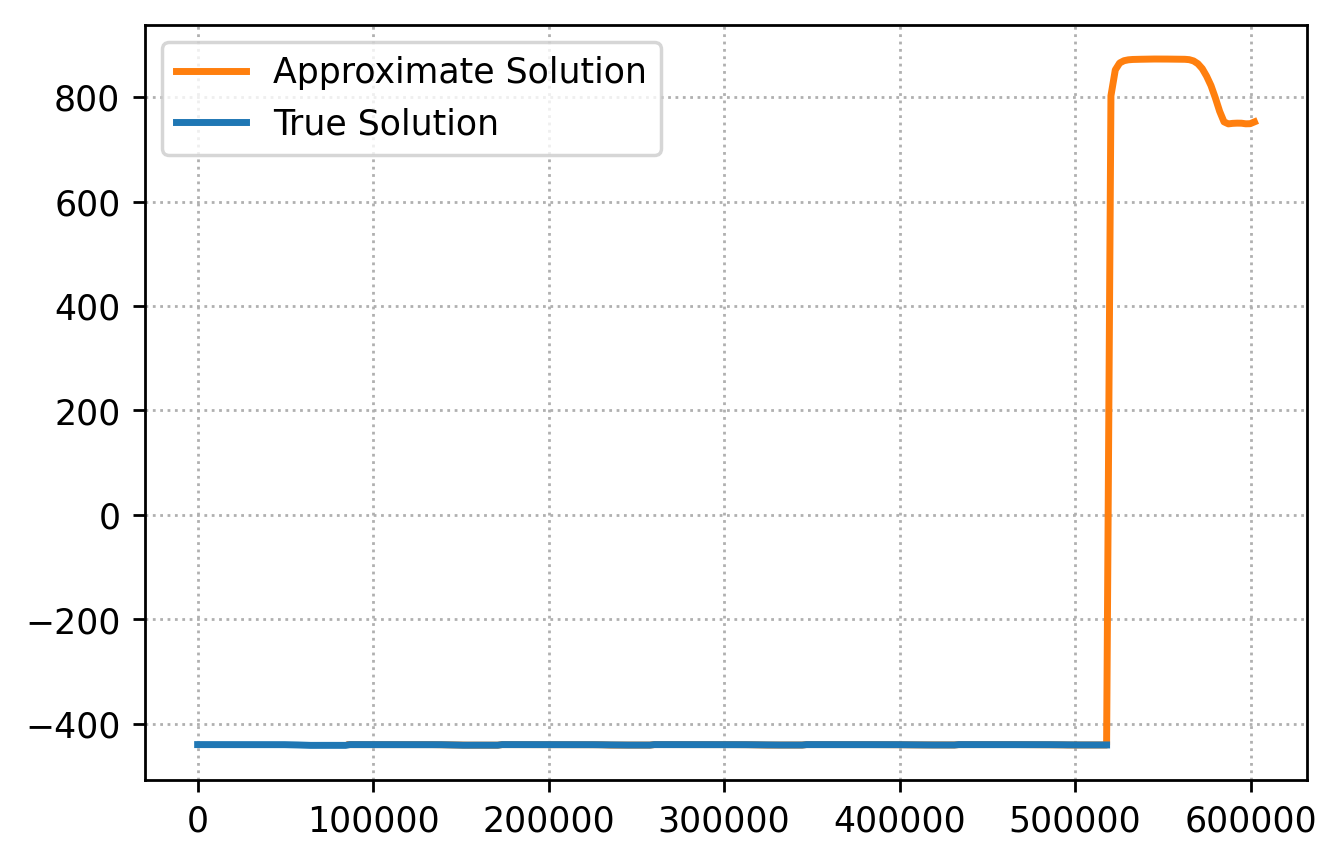

In [10]:
test_read = pd.read_csv(r'C:\Users\matth\OneDrive\Documents\TestingData.txt')
test_read = test_read.iloc[:,0:1].values
test_read = torch.tensor(test_read).to(torch.float64).squeeze(1).to(device)
test_read /= 602168.58

saved_pred = pd.read_csv(r'C:\Users\matth\OneDrive\Documents\tensor_data.txt')
saved_pred = saved_pred.iloc[:,1:3].values
saved_pred = torch.tensor(saved_pred).to(torch.float64).unsqueeze(0).to(device)


output_function_test_0 = fno(input_function_train[0,:,:].unsqueeze(0))
output_function_test_1 = fno(input_function_train[1,:,:].unsqueeze(0))
output_function_test_2 = fno(input_function_train[2,:,:].unsqueeze(0))
output_function_test_3 = fno(input_function_train[3,:,:].unsqueeze(0))
output_function_test_4 = fno(input_function_train[4,:,:].unsqueeze(0))
output_function_test_5 = fno(data_read[:,175:210].to(device))

saved_pred[:,:,0] /= max_Tf
saved_pred[:,:,1] /= max_Ts
print(saved_pred.shape)
input_function_pred = 602168.58 * torch.cat((input_function_train[1,:,2], input_function_train[2,:,2], input_function_train[3,:,2], input_function_train[4,:,2], data_read[:,175:210,2].squeeze(0).to(device), test_read), dim=0)
output_function_pred = torch.cat((output_function_test_0, output_function_test_1, output_function_test_2, output_function_test_3, output_function_test_4, saved_pred), dim=1)
print(input_function_pred.shape, output_function_pred.shape)

input_function_plot = 602168.58 * torch.cat((input_function_train[0,:,2], input_function_train[1,:,2], input_function_train[2,:,2], input_function_train[3,:,2], input_function_train[4,:,2], data_read[:,175:210,2].squeeze(0).to(device)), dim=0)
output_function_plot = torch.cat((input_function_train[0,:,0:2], input_function_train[1,:,0:2], input_function_train[2,:,0:2], input_function_train[3,:,0:2], input_function_train[4,:,0:2], output_function_train[4,:,0:2]), dim=0)



plt.figure(dpi=1000)
plt.grid(True, which="both", ls=":")
print(output_function_pred.shape)
plt.plot(input_function_pred.cpu().detach(), max_Tf * output_function_pred[:,:,0].squeeze(0).cpu().detach(), label="Approximate Solution", c="C1", lw=0.5)
plt.plot(input_function_plot.cpu().detach(), max_Tf * output_function_plot[:,0].cpu().detach(), label="True Solution", c="C0", lw=0.5)


plt.legend()
plt.show()

plt.figure(dpi=250)
plt.grid(True, which="both", ls=":")

plt.plot(input_function_pred.cpu().detach(), max_Ts * output_function_pred[:,:,1].squeeze(0).cpu().detach(), label="Approximate Solution", c="C1", lw=2)
plt.plot(input_function_plot.cpu().detach(), max_Ts * output_function_plot[:,1].cpu().detach(), label="True Solution", c="C0", lw=2)


plt.legend()
plt.show()


In [13]:
# Create a DataFrame from the numpy array
test_read = pd.read_csv(r'C:\Users\matth\OneDrive\Documents\TestingData.txt')
test_read = test_read.iloc[:,0:1].values
test_read = torch.tensor(test_read, dtype=torch.float64).squeeze(1).to(device)
submission = torch.empty(34,3)
submission[:, 0] = test_read
submission[:, 1:3] = output_function_test_5[0,:34, 0:2] 
submission[:, 1] = submission[:, 1] * (max_Tf - min_Tf) + torch.full_like(submission[:, 1], min_Tf)
submission[:, 2] = submission[:, 2] * (max_Ts - min_Ts) + torch.full_like(submission[:, 2], min_Ts)

submission = pd.DataFrame(submission.detach().numpy())

# Save the DataFrame as a text file
submission.to_csv(r'C:\Users\matth\OneDrive\Documents\submissiontask3_FIIIINALLLL.txt', sep=',', index=False, header=['t', 'tf0', 'ts0'])

(34, 3)


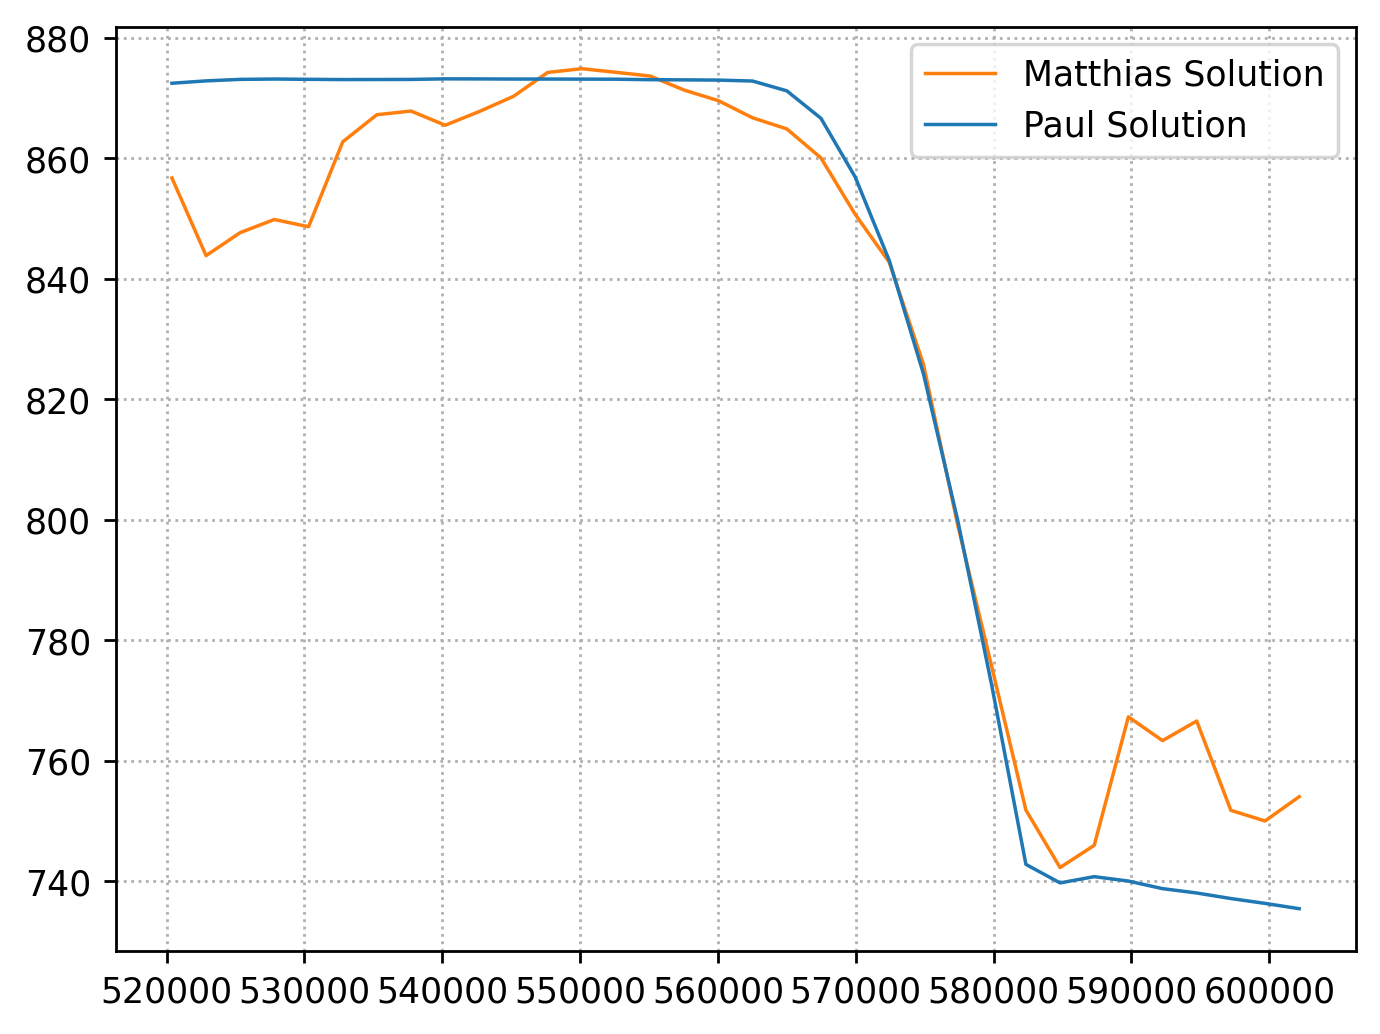

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
data_tens = pd.read_csv(r'C:\Users\matth\OneDrive\Documents\submission3_morenodes.txt')
print(data_tens.shape)
subp = pd.read_csv(r'C:\Users\matth\OneDrive\Documents\submissiontask3_FIIIINALLLL.txt')
y_1 = data_tens.iloc[:,0:3].values
y_2 = subp.iloc[:,0:3].values

y_1 = torch.tensor(y_1).to(torch.float64).squeeze(1)
y_2 = torch.tensor(y_2).to(torch.float64).squeeze(1)



plt.figure(dpi=250)
plt.grid(True, which="both", ls=":")

plt.plot(y_1[:,0].cpu().detach(), y_1[:,1].cpu().detach(), label="Matthias Solution", c="C1", lw=1)
plt.plot(y_2[:,0].cpu().detach(), y_2[:,1].cpu().detach(), label="Paul Solution", c="C0", lw=1)
plt.legend()
plt.show()
